In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from model import DotPerception, build_network

In [2]:
palette = sns.color_palette("colorblind")
palette2 = sns.color_palette("tab10")[2:4]
palette3 = sns.color_palette("viridis", 10)
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [3]:
def single_trial(coherence, nActions, ramp=1, relative=0, threshold=0.5, perception_seed=0, network_seed=0,
                 max_rates=nengo.dists.Uniform(100, 200), dt=0.001, dt_sample=0.01, tmax=5, sigma=0.3, nNeurons=500, rA=4, legend=True, name="single"):

    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
    inputs.create(coherence=coherence)
    net = build_network(inputs, nNeurons=nNeurons, nActions=nActions, seed=network_seed, ramp=ramp, threshold=threshold,
                        relative=relative, rA=rA, max_rates=max_rates)
    sim = nengo.Simulator(net, progress_bar=False)
    choice = None
    RT = None
    while choice==None:
        sim.run(dt)
        if np.any(sim.data[net.pAction][-1,:] > 0.01):
            choice = np.argmax(sim.data[net.pAction][-1,:])
            RT = sim.trange()[-1]
        if sim.trange()[-1] > tmax:
            choice = np.argmax(sim.data[net.pValue][-1,:])
            RT = sim.trange()[-1]
        correct = 1 if choice==net.inputs.correct else 0
    print(RT)
    # print(inputs.motions)
    # print(choice, net.inputs.correct)

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=((7, 2.5)))
    for a in range(nActions):
        axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,a], color=palette[a], label=f"Estimate {a}", lw=0.5) 
        axes[1].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a], label=f"Value {a}") 
    for a in range(nActions):
        if dt_sample is not None:
            ideal = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
            axes[0].plot(sim.trange(), ideal, color=palette[a], label=f"True {a}", linestyle="--") 
#     axes[1].plot(sim.trange(), sim.data[net.pGate], label='threshold', color="black")
    axes[1].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), label='Threshold', color="red", linestyle=":")
    axes[0].set(ylabel=r"$\mathbf{M}(t)$", xlabel="Time (s)", title=f"Cumulative Motion (seed {perception_seed})")
    axes[1].set(ylabel=r"$\mathbf{V}(t)$", xlabel="Time (s)", title=r"Value ($L=$"+f"{relative})")
    if legend:
        axes[0].legend(loc='upper left', ncol=2)
        leg = axes[1].legend(loc='lower right')
        leg.get_texts()[choice].set_color("lime" if correct else "red")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

## Results

0.6890000000000001


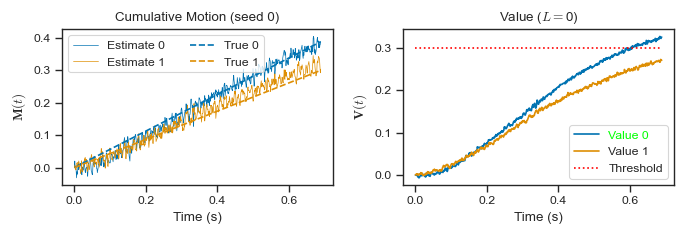

In [152]:
single_trial(coherence=0.128, nActions=2, ramp=1, threshold=0.3, relative=0, network_seed=0, perception_seed=0, rA=2.0, name="dynamics1")

0.764


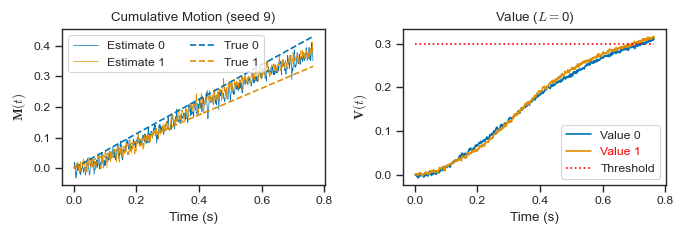

In [153]:
single_trial(coherence=0.128, nActions=2, ramp=1, threshold=0.3, relative=0, network_seed=0, perception_seed=9, rA=2.0, name="dynamics2")

2.718


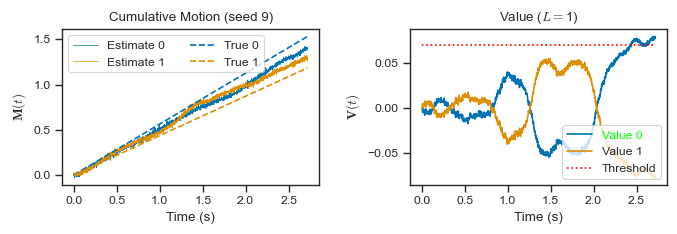

In [154]:
single_trial(coherence=0.128, nActions=2, ramp=1, threshold=0.07, relative=1, network_seed=0, perception_seed=9, rA=2.0, name="dynamics3")

0.879


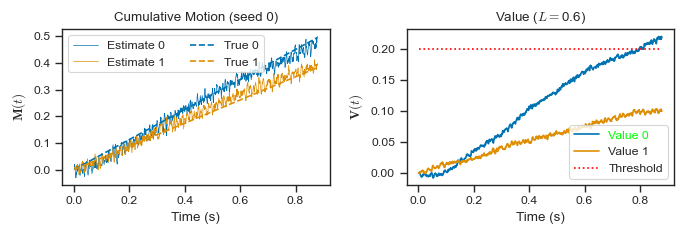

In [157]:
single_trial(coherence=0.128, nActions=2, ramp=1, threshold=0.2, relative=0.6, network_seed=0, perception_seed=0, rA=2.0, name="dynamics4")

1.165


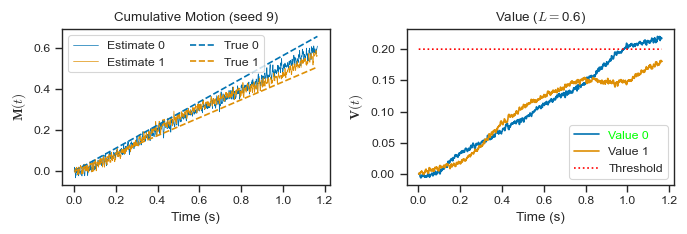

In [158]:
single_trial(coherence=0.128, nActions=2, ramp=1, threshold=0.2, relative=0.6, network_seed=0, perception_seed=9, rA=2.0, name="dynamics5")

In [5]:
def multiple_trial(coherence,
                   trials=3,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_sample=0.01,
                   sigma=0.3,
                   ramp=1,
                   threshold=0.5,
                   relative=0,
                   rA=4,
                   nActions=2,
                   nNeurons=500,
                   max_rates=nengo.dists.Uniform(100, 200),
                   tmax=5,
                   name="multiple_trials",
                   **kwargs):
    
    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
    inputs.create(coherence=coherence, correct=0)  # force the correct choice to be zero on each trial
    dfs_dynamics = []
    for trial in range(trials):
        net = build_network(inputs, nActions=nActions, seed=trial, ramp=ramp, threshold=threshold, relative=relative, rA=rA,
                            max_rates=max_rates, nNeurons=nNeurons)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        RT = None
        while choice==None:
            sim.run(dt)
            if np.any(sim.data[net.pAction][-1,:] > 0.01):
                choice = np.argmax(sim.data[net.pAction][-1,:])
                RT = sim.trange()[-1]
            if sim.trange()[-1] > tmax:
                choice = np.argmax(sim.data[net.pValue][-1,:])
                RT = sim.trange()[-1]
        print(f"trial {trial}, coherence {coherence}, choice {choice}, correct {net.inputs.correct}, RT {RT}")
        correct = 1 if choice==net.inputs.correct else 0
        if choice is not None:
            correct = 1 if choice==net.inputs.correct else 0
            df = pd.DataFrame()
            df['coherence'] = coherence*np.ones_like(sim.trange())
            df['trial'] = trial*np.ones_like(sim.trange())
            df['threshold'] = threshold*np.ones_like(sim.trange())
            df['time'] = sim.trange()
            df['accuracy'] = 100*correct*np.ones_like(sim.trange())
            df['RT'] = 1000*RT*np.ones_like(sim.trange())
            for a in range(nActions):
                df[f'ideal {a}'] = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
                df[f'evidence {a}'] = sim.data[net.pAccumulator][:,a].ravel()
                df[f'value {a}'] = sim.data[net.pValue][:,a].ravel()
            dfs_dynamics.append(df)

    data = pd.concat(dfs_dynamics, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((3.5, 3)))
    subdata_correct = data.query("accuracy==100")
    subdata_incorrect = data.query("accuracy==0")
    if not subdata_correct.empty:
        sns.lineplot(data=subdata_correct, x='time', y='value 0', units='trial', estimator=None, lw=0.2, color=palette2[0], ax=ax)
    if not subdata_incorrect.empty:
        sns.lineplot(data=subdata_incorrect, x='time', y='value 0', units='trial', estimator=None, lw=0.2, color=palette2[1], ax=ax)
        # sns.lineplot(data=subdata_incorrect, x='time', y='value 1', units='trial', estimator=None, lw=0.2, color=palette2[0], ax=ax)
    sns.lineplot(data=data, x='time', y='ideal 0', color=palette[0], linestyle="--", estimator=None, ax=ax)
    sns.lineplot(data=data, x='time', y='threshold', color="red", linestyle=":", estimator=None, ax=ax)
    ax.set(xlabel="Time (s)", ylabel=r"$\hat{\mathbf{x}}(t)$", ylim=((-0.05, threshold+0.05)))
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

In [ ]:
multiple_trial(coherence=0.128, ramp=1, threshold=0.5, relative=0.5, rA=2.0, trials=10, perception_seed=0)

In [ ]:
multiple_trial(coherence=0.128, trials=20, perception_seed=0, max_rates=nengo.dists.Uniform(70, 100))

In [18]:
def scan_dtsample_sigma(
        coherence,
        dt_samples,
        sigmas,
        trials=10,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        ramp=1,
        threshold=0.5,
        relative=0,
        nNeurons=500,
        rA=4,
        nActions=2,
        tmax=5,
        set_correct=0,
        max_rates=nengo.dists.Uniform(100, 200),
        name="scan_dtsample_sigma",
        bins = np.arange(0.0, 2.0, 0.2),
        load=False):

    ts_string = r"$t_s$"
    sigma_string = r"$\sigma$"
    if not load:
        dfs = []
        dfs2 = []
        for dt_sample in dt_samples:
            for sigma in sigmas:
                inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
                inputs.create(coherence=coherence, correct=set_correct)  # force the correct choice to be "zero" on each trial
                for trial in range(trials):
                    print(f"trial {trial}, coherence {coherence}, dt_sample {dt_sample}, sigma {sigma}")
                    # net = build_network(inputs, nActions=nActions, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative, rA=rA, nNeurons=nNeurons)
                    net = build_network(inputs, nActions=nActions, seed=trial, ramp=ramp, threshold=threshold, relative=relative, rA=rA,
                                        nNeurons=nNeurons, max_rates=max_rates)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    RT = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0.01):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > tmax:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    # correct = 1 if choice==net.inputs.correct else 0
                    correct = 1 if choice==set_correct else 0
                    df = pd.DataFrame()
                    df['coherence'] = coherence*np.ones_like(sim.trange())
                    df['trial'] = trial*np.ones_like(sim.trange())
                    df['threshold'] = threshold*np.ones_like(sim.trange())
                    df[ts_string] = dt_sample*np.ones_like(sim.trange())
                    df[sigma_string] = sigma*np.ones_like(sim.trange())
                    df['time'] = sim.trange()
                    df['accuracy'] = 100*correct*np.ones_like(sim.trange())
                    df['RT'] = RT*np.ones_like(sim.trange())
                    for a in range(nActions):
                        df[f'ideal {a}'] = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
                        df[f'evidence {a}'] = sim.data[net.pAccumulator][:,a].ravel()
                        df[f'value {a}'] = sim.data[net.pValue][:,a].ravel()
                    dfs.append(df)
                    dfs2.append(pd.DataFrame([[trial, f"{coherence}", f"{dt_sample}", f"{sigma}", RT, 100*correct]],
                                             columns=('trial', 'coherence', ts_string, sigma_string, 'RT', 'accuracy')))
        data = pd.concat(dfs, ignore_index=True)
        data2 = pd.concat(dfs2, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
        data2.to_pickle(f"data/{name}_result.pkl")

    else:
        data = pd.read_pickle(f"data/{name}.pkl")
        data2 = pd.read_pickle(f"data/{name}_result.pkl")

    fig = sns.FacetGrid(data, row=ts_string, col=sigma_string, hue='accuracy', hue_order=[100, 0],
                        palette=palette[:2], height=1.3, aspect=1.5, sharex=True, legend_out=True)
    fig.map_dataframe(sns.lineplot, x="time", y='value 0', units='trial', estimator=None, lw=0.4)
    fig.add_legend()
    fig.set_ylabels(r"$V_0(t)$")
    fig.set(yticks=[0.0, threshold])
    fig.set_xlabels("Time (s)")
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

    fig = sns.FacetGrid(data, row=ts_string, col=sigma_string, palette=palette[0], height=1.3, aspect=1.5, sharex=True)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", bins=bins, common_norm=False)
    fig.add_legend()
    fig.set(xticks=bins[::2])
    fig.set_ylabels("Percent")
    fig.set_xlabels("Response Time (s)")
    fig.savefig(f"plots/{name}_RT_distributions.svg")
    fig.savefig(f"plots/{name}_RT_distributions.png", dpi=600)

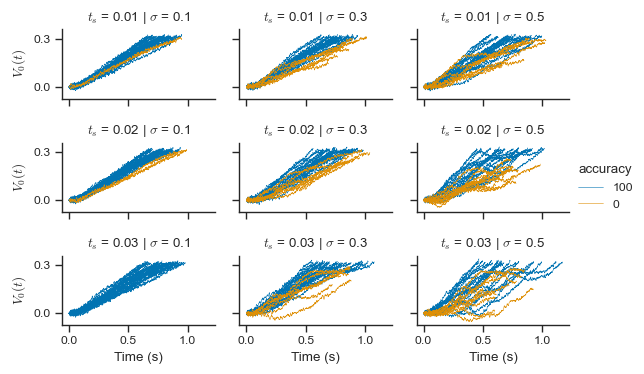

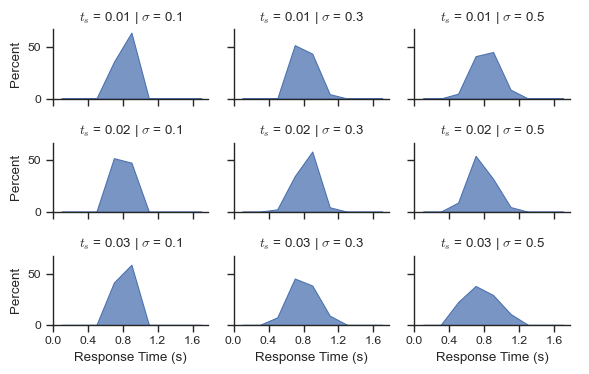

In [19]:
scan_dtsample_sigma(coherence=0.064, ramp=1.5, threshold=0.3, relative=0.5, rA=1.5, nNeurons=500, max_rates=nengo.dists.Uniform(80, 100),
                    dt_samples=[0.01, 0.02, 0.03], sigmas=[0.1, 0.3, 0.5], trials=30, load=True)

In [12]:
def vary_ramp_threshold(coherence,
                   trials=3,
                   nActions=2,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_sample=0.02,
                   ramps=[0.5, 1],
                   thresholds=[0.3, 0.5],
                   relative=0,
                   tmax=5,
                   rA=4,
                   nNeurons=2000,
                   name="vary_ramp_threshold"):

    dfs = []
    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed)
    inputs.create(coherence=coherence, correct=0)  # force choice "zero" to be correct
    for ramp in ramps:
        for threshold in thresholds:
            for trial in range(trials):
                print(f"trial {trial}, ramp {ramp}, threshold {threshold}")
                net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative, rA=rA, nNeurons=nNeurons)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > tmax:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = 1 if choice==net.inputs.correct else 0
                df = pd.DataFrame()
                df['coherence'] = coherence*np.ones_like(sim.trange())
                df['trial'] = trial*np.ones_like(sim.trange())
                df['threshold'] = threshold*np.ones_like(sim.trange())
                df['ramp'] = ramp*np.ones_like(sim.trange())
                df['dt_sample'] = dt_sample*np.ones_like(sim.trange())
                df['time'] = sim.trange()
                df['accuracy'] = 100*correct*np.ones_like(sim.trange())
                df['RT'] = 1000*RT*np.ones_like(sim.trange())
                for a in range(nActions):
                    df[f'ideal {a}'] = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
                    df[f'evidence {a}'] = sim.data[net.pAccumulator][:,a].ravel()
                    df[f'value {a}'] = sim.data[net.pValue][:,a].ravel()
                dfs.append(df)

    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((7.08, 4)))
    for r in range(len(ramps)):
        for t in range(len(thresholds)):
            ramp, threshold = ramps[r], thresholds[t]
            subdata = data.query("ramp==@ramp & threshold==@threshold")
            subdata_correct = subdata.query("accuracy==100")
            subdata_incorrect = subdata.query("accuracy==0")
            if not subdata_correct.empty:
                sns.lineplot(data=subdata_correct, x='time', y='value 0', units='trial', estimator=None, lw=0.2, color=palette2[0], ax=axes[r][t])
            if not subdata_incorrect.empty:
                sns.lineplot(data=subdata_incorrect, x='time', y='value 0', units='trial', estimator=None, lw=0.2, color=palette2[1], ax=axes[r][t])            
            sns.lineplot(data=subdata, x='time', y='ideal 0', color=palette[0], linestyle="--", estimator=None, ax=axes[r][t])
            sns.lineplot(data=subdata, x='time', y='threshold', color="red", linestyle=":", estimator=None, ax=axes[r][t])
            axes[r][t].set(xlabel="Time (s)", ylabel=r"$\hat{\mathbf{x}}(t)$", title=f"ramp {ramp}, threshold {threshold}", ylim=((-0.05, threshold+0.05)))
    axes[0][0].set(ylabel=r"$\hat{\mathbf{x}}(t)$")
    axes[1][0].set(xlabel="Time (s)")
    axes[1][1].set(ylabel=r"$\hat{\mathbf{x}}(t)$", xlabel="Time (s)")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

In [ ]:
vary_ramp_threshold(coherence=0.1, trials=30)

In [7]:
def scan_coherence(
        coherences=[0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512],
        ramp=1,
        threshold=0.5,
        sigma=0.3,
        nActions=2,
        nNeurons=200,
        trials=3,
        perception_seed=0,
        dt=0.001,
        dt_sample=0.01,
        relative=0,
        load=False,
        error=('ci', 95),  # ("pi", 50),
        tmax=10,
        condition='normal',  # just for labelling data and plotting empirical validation
        name="scan_coherence"):
    
    if not load:
        network_seed = 0
        columns = ('type', 'name', 'trial', 'coherence', 'RT', 'accuracy', 'condition')  # same as Palmer dataframe
        dfs = []
        for c, coherence in enumerate(coherences):
            inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=int(1000*coherence), sigma=sigma)
            print(f"coherence {coherence}")
            for trial in range(trials):
                # print(f"trial {trial}, coherence {coherence}")
                inputs.create(coherence=coherence)
                net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, seed=trial, ramp=ramp, threshold=threshold, relative=relative)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > tmax:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = True if choice==inputs.correct else False
                # print(RT, 100*correct)
                label = f"ramp {ramp}, thr {threshold}"
                dfs.append(pd.DataFrame([['model', '0', trial, 100*coherence, RT, 100*correct, condition]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
    else:
        data = pd.read_pickle(f"data/{name}.pkl")

    palmer = pd.read_pickle('data/palmer2005.pkl').query("name=='JP' & condition==@condition")
    combined = pd.concat([palmer, data])
    # for coherence in combined['coherence'].unique():
    #     rts_sim = combined.query("coherence==@coherence & type=='model'")['RT'].to_numpy()
    #     rts_emp = combined.query("coherence==@coherence & type=='human'")['RT'].to_numpy()
    #     print(f"coherence {coherence}, mean sim {np.mean(rts_sim)}, mean emp {np.mean(rts_emp)}")

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=((7.08, 2)))
    sns.lineplot(data=combined, x='coherence', y='RT', hue='type', style="type", palette=palette[:2], markers=True, errorbar=error, ax=axes[0])
    sns.lineplot(data=combined, x='coherence', y='accuracy', hue="type", style="type", palette=palette[:2], markers=True, ax=axes[1])  # errorbar=error,
    axes[0].set(xlabel="Coherence (%)", ylabel="Response Time (s)")
    axes[0].set_xscale('log')
    axes[1].set(xlabel="Coherence (%)", xlim=((0.5, 100)), ylabel="Accuracy (%)", ylim=((45, 105)), yticks=((50, 60, 70, 80, 90, 100)))
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/compare_palmer_model.svg")
    fig.savefig(f"plots/compare_palmer_model.png", dpi=600)

    if condition=="speed":
        bins = np.arange(0.0, 1.0, 0.1)
    if condition=="normal":
        bins = np.arange(0.0, 2.0, 0.2)
    if condition=="accuracy":
        bins = np.arange(0.0, 4.0, 0.4)
    fig = sns.FacetGrid(combined, col="coherence", hue='type', palette=palette[:2], height=1.5, aspect=1.5, col_wrap=4, sharex=True)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    fig.savefig(f"plots/compare_palmer_model_RTs.svg")
    fig.savefig(f"plots/compare_palmer_model_RTs.png", dpi=600)

In [ ]:
scan_coherence(ramp=1.6, threshold=0.2, relative=0.5, trials=50, name="sigma3", condition="speed", nNeurons=200, dt_sample=0.01, sigma=0.3, load=False)

In [14]:
def scan_coherence_ramp_threshold(
        coherences=np.geomspace(0.01, 1.0, 5),
        ramps=[0.5, 1.0],
        thresholds=[0.3, 0.6],
        nActions=2,
        trials=3,
        perception_seed=0,
        dt=0.001,
        dt_sample=0.02,
        relative=0,
        load=False,
        errbar="se",
        tmax=5,
        RTmin=0.2,
        name="scan_coherence_ramp_threshold"):
    
    if not load:
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed)
        network_seed = 0
        columns = ('label', 'ramp', 'threshold', 'coherence', 'trial', 'RT', 'accuracy')
        dfs = []
        for ramp in ramps:
            for threshold in thresholds:
                for coherence in coherences:
                    for trial in range(trials):
                        print(f"trial {trial}, coherence {coherence}, ramp {ramp}, threshold {threshold}")
                        network_seed += 1
                        inputs.create(coherence=coherence)
                        net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)
                        sim = nengo.Simulator(net, progress_bar=False)
                        choice = None
                        while choice==None:
                            sim.run(dt)
                            if np.any(sim.data[net.pAction][-1,:] > 0):
                                choice = np.argmax(sim.data[net.pAction][-1,:])
                                RT = sim.trange()[-1]
                            if sim.trange()[-1] > tmax:
                                choice = np.argmax(sim.data[net.pValue][-1,:])
                                RT = sim.trange()[-1]
                        correct = True if choice==inputs.correct else False
                        if RT > RTmin:
                            label = f"ramp {ramp}, thr {threshold}"
                            dfs.append(pd.DataFrame([[label, ramp, threshold, 100*coherence, trial, RT, 100*correct]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
    else:
        data = pd.read_pickle(f"data/{name}.pkl")
    
    fig, axes = plt.subplots(nrows=len(ramps), ncols=len(thresholds), sharex=True, sharey=True, figsize=((7.08, 2*len(ramps))))
    for r in range(len(ramps)):
        for t in range(len(thresholds)):
            ramp, threshold = ramps[r], thresholds[t]
            sns.lineplot(data=data.query("ramp==@ramp & threshold==@threshold"), x='coherence', y='RT', errorbar=errbar, ax=axes[r][t])
            axes[r][t].set(title=f"ramp {ramp}, threshold {threshold}")
    for r in range(len(ramps)):
        axes[r][0].set(ylabel="Response Times (s)")
    for t in range(len(thresholds)):
        axes[len(ramps)-1][t].set(xlabel="Coherence (% motion strength)")
    plt.xscale('log')
    plt.tight_layout()
    fig.savefig(f"plots/{name}_RT.svg")
    fig.savefig(f"plots/{name}_RT.png", dpi=600)

    fig, axes = plt.subplots(nrows=len(ramps), ncols=len(thresholds), sharex=True, sharey=True, figsize=((7.08, 2*len(ramps))))
    for r in range(len(ramps)):
        for t in range(len(thresholds)):
            ramp, threshold = ramps[r], thresholds[t]
            sns.lineplot(data=data.query("ramp==@ramp & threshold==@threshold"), x='coherence', y='accuracy', errorbar=errbar, ax=axes[r][t])
            axes[r][t].set(title=f"ramp {ramp}, threshold {threshold}")
    for r in range(len(ramps)):
        axes[r][0].set(ylabel="Accuracy (%)")
    for t in range(len(thresholds)):
        axes[len(ramps)-1][t].set(xlabel="Coherence (% motion strength)")
    plt.xscale('log')
    plt.tight_layout()
    fig.savefig(f"plots/{name}_accuracy.svg")
    fig.savefig(f"plots/{name}_accuracy.png", dpi=600)

    fig = sns.FacetGrid(data, row="coherence", hue="label", palette=palette, height=1.15, aspect=3)
    fig.map_dataframe(sns.histplot, x="RT", stat='probability', element="poly", bins=np.arange(0.2, 2.6, 0.2), common_norm=False)
    fig.set_xlabels("Reaction Time (s)")
    fig.add_legend()
    fig.savefig(f"plots/{name}_distributions.svg")
    fig.savefig(f"plots/{name}_distributions.png", dpi=600)

In [ ]:
scan_coherence_ramp_threshold(
        load=True,
        coherences=[0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512],
        ramps=[0.5, 1.0],
        thresholds=[0.3, 0.5],
        trials=10)

In [18]:
def scan_coherence_nActions(
        coherences=np.geomspace(0.01, 1.0, 5),
        nActions_list=[2, 4],
        ramp=1.0,
        threshold=0.5,
        trials=3,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        dt_sample=0.02,
        relative=0,
        load=False,
        tmax=5,
        RTmin=0.2,
        name="scan_coherence_nActions"):
    
    if not load:
        columns = ('nActions', 'coherence', 'trial', 'RT', 'accuracy')
        dfs = []
        for nActions in nActions_list:
            inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed)
            for coherence in coherences:
                for trial in range(trials):
                    print(f"trial {trial}, coherence {coherence}, nActions {nActions}")
                    network_seed += 1
                    inputs.create(coherence=coherence)
                    net = build_network(inputs, nActions=nActions, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > tmax:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    correct = True if choice==inputs.correct else False
                    if RT > RTmin:
                        dfs.append(pd.DataFrame([[f"{nActions}", 100*coherence, trial, RT, 100*correct]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
    else:
        data = pd.read_pickle(f"data/{name}.pkl")
    
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=data, x='coherence', y='RT', hue='nActions', ax=axes[0])
    sns.lineplot(data=data, x='coherence', y='accuracy', hue='nActions', ax=axes[1])
    axes[0].set(ylabel="Response Times (s)")
    axes[1].set(ylabel="Accuracy (%)", xlabel="Coherence (% motion strength)")
    plt.xscale('log')
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/{name}_RT.svg")
    fig.savefig(f"plots/{name}_RT.png", dpi=600)

    palette3 = sns.color_palette("viridis", len(coherences))
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=((7.08, 3)))
    sns.histplot(data=data.query("nActions=='2'"), x="RT", hue="coherence", stat='probability', element="poly",
                 bins=np.arange(0.2, 1.6, 0.1), common_norm=False, palette=palette3, ax=axes[0])
    sns.histplot(data=data.query("nActions=='4'"), x="RT", hue="coherence", stat='probability', element="poly",
                 bins=np.arange(0.2, 1.6, 0.1), common_norm=False, palette=palette3, ax=axes[1])
    axes[0].set(xlabel='Response Time (s)', ylabel="Probability", title='2 Actions')
    axes[1].set(title='4 Actions')
    plt.tight_layout()
    fig.savefig(f"plots/{name}_distributions.svg")
    fig.savefig(f"plots/{name}_distributions.png", dpi=600)

In [ ]:
scan_coherence_nActions(load=False, coherences=[0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0], threshold=0.25, trials=30)